# Высокочастотные фильтры

Автор: Винник Екатерина Петровна, 22.М04


## Идеальный, Баттерворта, Гаусса
### Теория

Поскольку контуры и другие скачкообразные изменения яркости связаны с высокочастотными составляющими, повышение резкости изображения может быть достигнуто при помощи процедуры высокочастотной фильтрации в частотной области, которая подавляет низкочастотные составляющие и не затрагивает высокочастотную часть Фурье-преобразования. Фильтры высоких частот получаются вычитанием из 1 фильтров низких частот, и поэтому имеют аналогичные фильтрам низких частот свойства.
Рассмотрим три фильтра высоких частот -- идеальный, Баттерворта. Гаусса:
$$
\begin{equation}
    \begin{gathered}
        H(u, v) = 
        \begin{cases}
            0, \textrm{at } D(u, v) \leq D_0 \\
            1, \textrm{else};
        \end{cases} \\
        H(u, v) = \frac{(D(u, v) / D_0)^{2n}}{1 + (D(u, v) / D_0)^{2n}}; \\
        H(u, v) = 1 - \exp (-D^2(u, v) / 2 D_0); \\
    \end{gathered}
\end{equation}
$$
где $D(u, v)$ расстояние от центра изображения, $D_0$ константа.

### Реализация

#### Быстрое преобразование Фурье

In [1]:
import numpy as np


def get_fft(img, shift=False):
    h = img.shape[0]
    w = img.shape[1]
    img = img.astype(complex)
    
    x_arr = np.arange(h)
    y_arr = np.arange(w)
    
    x_mat = np.repeat(x_arr.reshape((h, 1)), w, 1)
    y_mat = np.repeat(y_arr.reshape((1, w)), h, 0)
    
    if shift:
        exp_val = (x_mat + y_mat) * np.pi * 1j
        img = np.multiply(img, np.exp(exp_val))
        
    if len(img.shape) == 3:
        img = np.swapaxes(img, 0, 2)
        img_fft = np.fft.fft2(img)
    else:
        img_fft = np.fft.fft2(img)
        
    return img_fft

#### Обратное быстрое преобразование Фурье

In [2]:
import numpy as np


def get_ifft(img_fft, shift=False):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    img_fft = img_fft.astype(complex)
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
     
    if shift:
        exp_val = (u_mat + v_mat) * np.pi * 1j
        img_fft = np.multiply(img_fft, np.exp(exp_val))
        
    if len(img_fft.shape) == 3:
        img_fft = np.swapaxes(img_fft, 0, 2)
        img_ifft = np.fft.ifft2(img_fft)
    else:
        img_ifft = np.fft.ifft2(img_fft)
        
    return img_ifft

#### Идеальный фильтр высоких частот

In [3]:
import numpy as np


def apply_ideal_HP(img_fft, d0perc=.5):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    
    d0 = d0perc * np.min([h, w]) / 2
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = np.zeros_like(dist_mat)
    filter_mat[dist_mat > d0] = 1.
    
    if len(img_fft.shape) == 3:
        channels = img_fft.shape[-1]
        for ch in range(channels):
            img_fft[:, :, ch] = np.multiply(img_fft[:, :, ch], filter_mat)
    else:
        img_fft = np.multiply(img_fft, filter_mat)
        
    return img_fft, filter_mat

#### Фильтр Баттерворта высоких частот

In [4]:
import numpy as np


def apply_bw_HP(img_fft, d0perc=.5, n=1):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    
    d0 = d0perc * np.min([h, w]) / 2
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = np.full_like(dist_mat, 1.) - 1 / (1 + np.power((dist_mat / d0), 2*n))
    
    if len(img_fft.shape) == 3:
        channels = img_fft.shape[-1]
        for ch in range(channels):
            img_fft[:, :, ch] = np.multiply(img_fft[:, :, ch], filter_mat)
    else:
        img_fft = np.multiply(img_fft, filter_mat)
        
    return img_fft, filter_mat

#### Фильтр Гаусса высоких частот

In [5]:
import numpy as np


def apply_gauss_HP(img_fft, d0perc=.5):
    h = img_fft.shape[0]
    w = img_fft.shape[1]
    
    d0 = d0perc * np.min([h, w]) / 2
    
    u_arr = np.arange(h)
    v_arr = np.arange(w)
    
    u_mat = np.repeat(u_arr.reshape((h, 1)), w, 1)
    v_mat = np.repeat(v_arr.reshape((1, w)), h, 0)
    
    dist_mat = np.sqrt(np.power((u_mat - h//2), 2) + np.power((v_mat - w//2), 2))
    
    filter_mat = np.full_like(dist_mat, 1.) - np.exp(-np.power(dist_mat, 2) / (2 * d0 * d0))
    
    if len(img_fft.shape) == 3:
        channels = img_fft.shape[-1]
        for ch in range(channels):
            img_fft[:, :, ch] = np.multiply(img_fft[:, :, ch], filter_mat)
    else:
        img_fft = np.multiply(img_fft, filter_mat)
        
    return img_fft, filter_mat

### Результаты применения фильтров к изображениям

Загрузим изображения для дальнейшей обработки.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


img_1 = Image.open('./text1.jpg')
img_2 = Image.open('./text2.jpg')

In [7]:
# represent the images as tensors
np_1 = np.array(img_1)
np_2 = np.array(img_2)
print('Picture dimensions:')
print(np_1.shape)
print(np_2.shape)

Picture dimensions:
(256, 256, 3)
(256, 256, 3)


In [8]:
# simplify the images by summing the channels
np_1_sum = np.sum(np_1, axis=2) // 3
np_2_sum = np.sum(np_2, axis=2) // 3

Применим быстрое преобразование Фурье к изображениям:

In [9]:
np_1_fft = get_fft(np_1_sum, True)
np_2_fft = get_fft(np_2_sum, True)

In [10]:
# log of abs

np_1_fft_logabs = np.log(np.abs(np_1_fft)+1)
np_2_fft_logabs = np.log(np.abs(np_2_fft)+1)

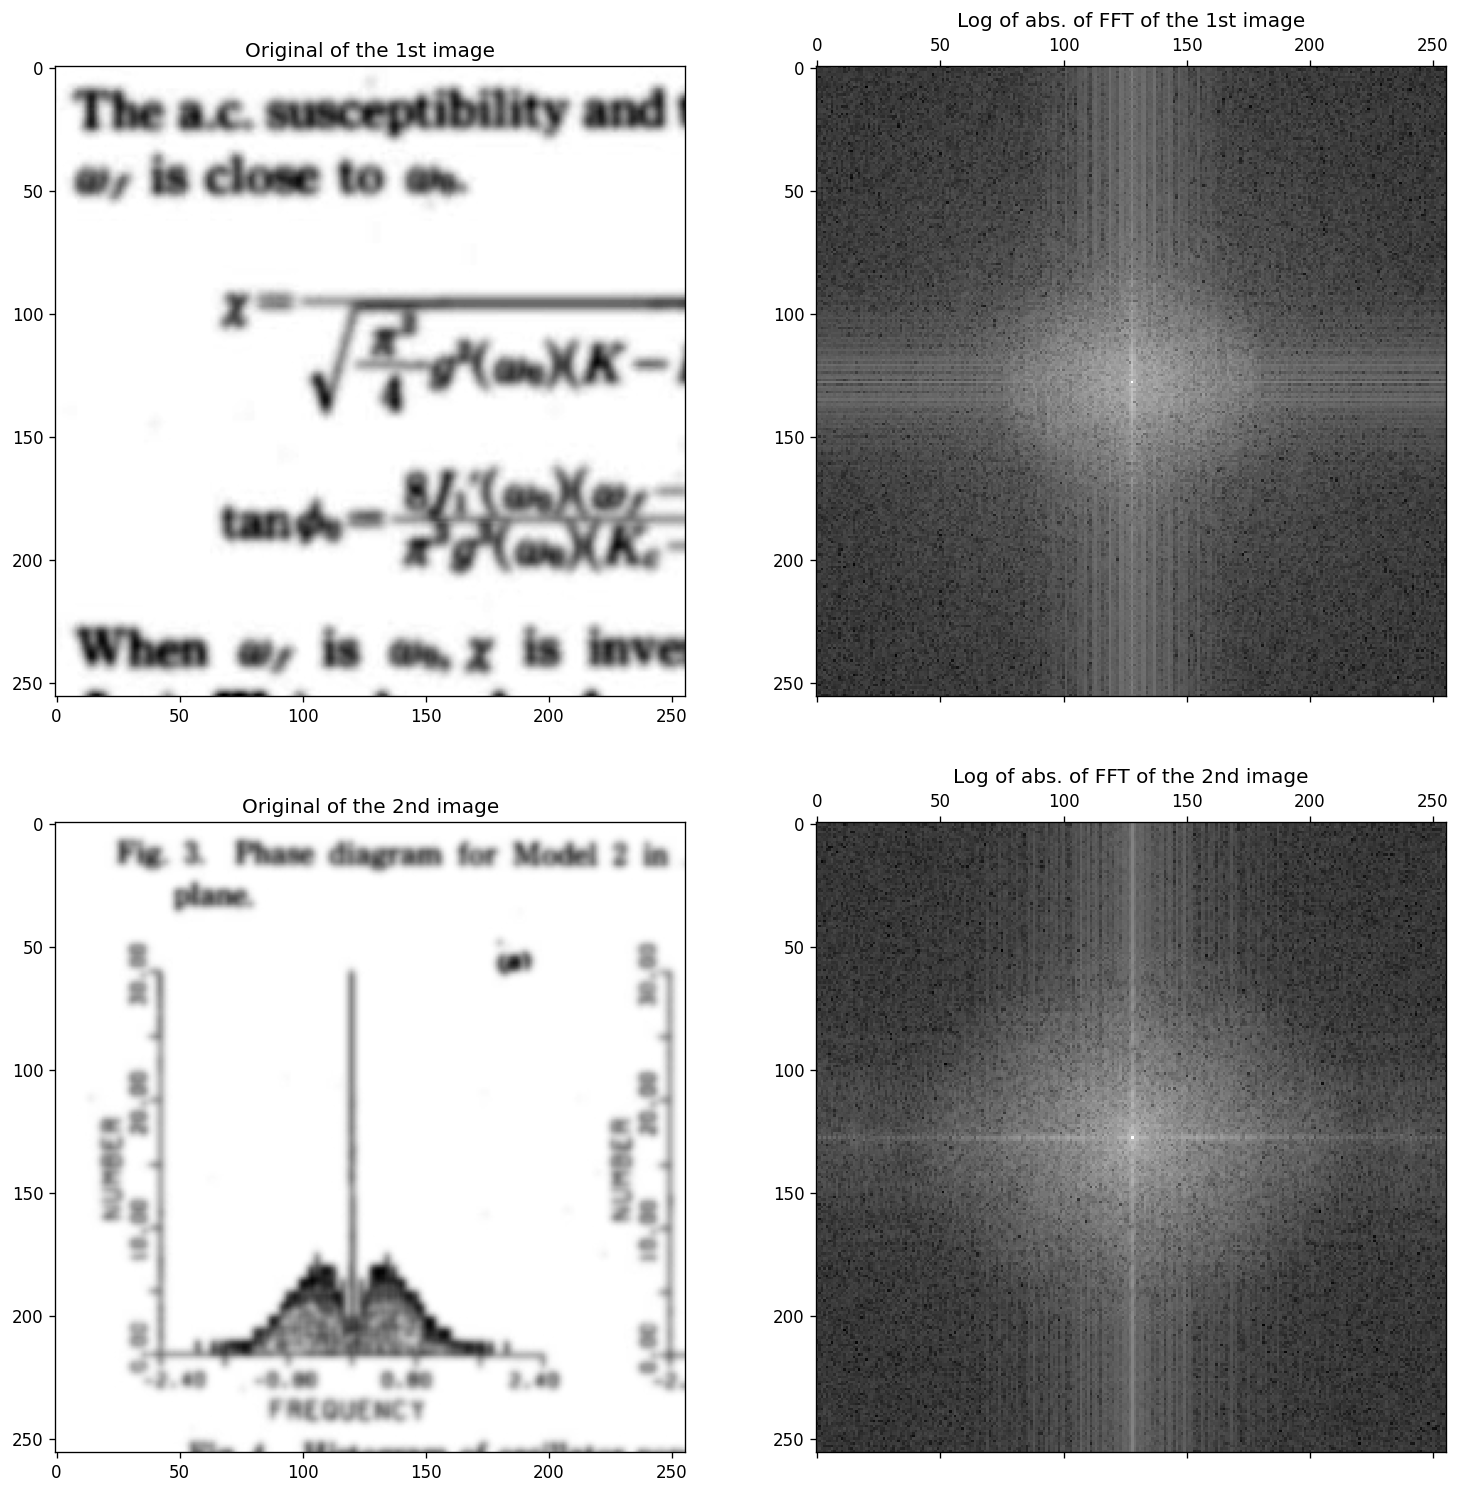

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].matshow(np_1_fft_logabs, cmap='gray')
axs[0, 1].set_title('Log of abs. of FFT of the 1st image')
axs[1, 0].imshow(np_2_sum, cmap='gray')
axs[1, 0].set_title('Original of the 2nd image')
axs[1, 1].matshow(np_2_fft_logabs, cmap='gray')
axs[1, 1].set_title('Log of abs. of FFT of the 2nd image')
plt.show()

Применим идеальный фильтр для различных значений $D_0$ (которое определяется как процент высоты изображения).

In [12]:
np_1_id1, _ = apply_ideal_HP(np_1_fft, .01)
np_1_id2, _ = apply_ideal_HP(np_1_fft, .05)
np_1_id3, _ = apply_ideal_HP(np_1_fft, .1)

np_1_id1i = np.abs(get_ifft(np_1_id1))
np_1_id2i = np.abs(get_ifft(np_1_id2))
np_1_id3i = np.abs(get_ifft(np_1_id3))

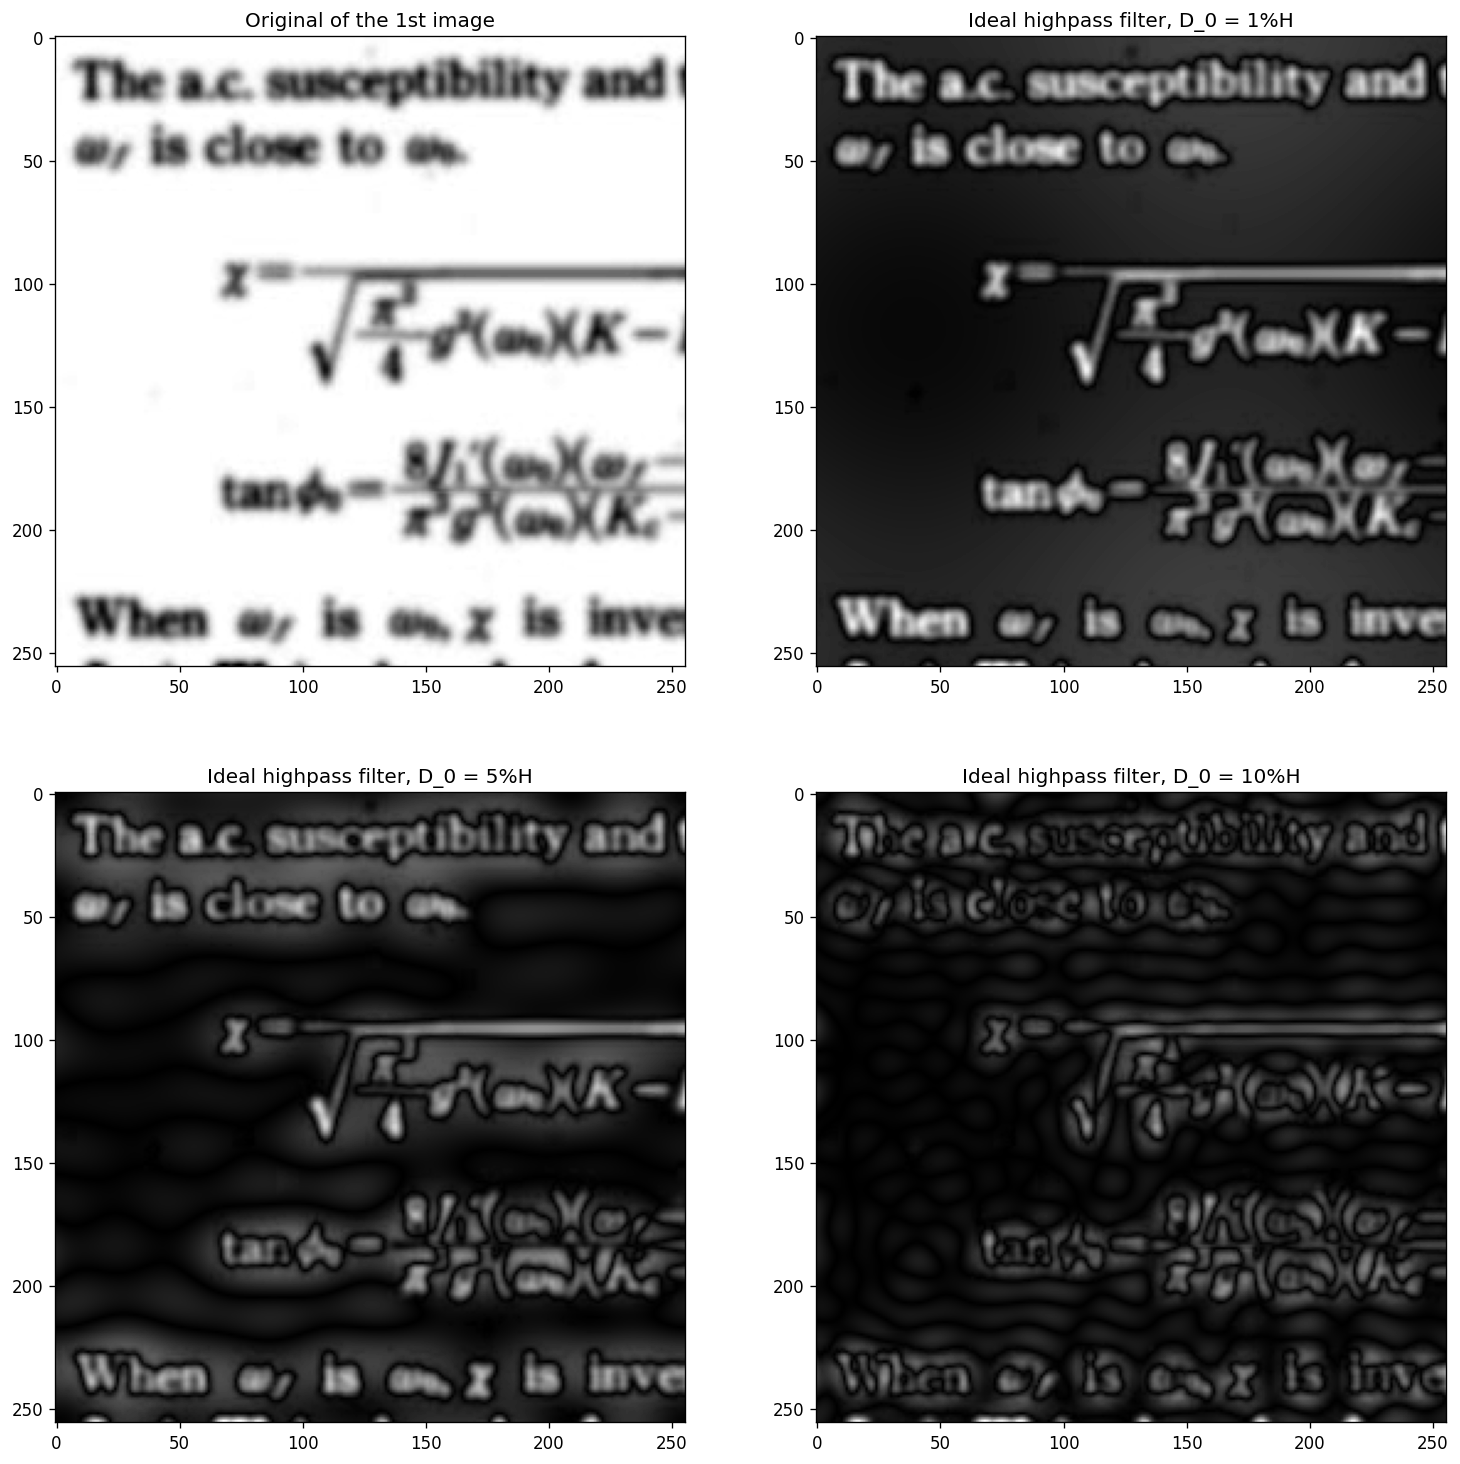

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_id1i, cmap='gray')
axs[0, 1].set_title('Ideal highpass filter, D_0 = 1%H')
axs[1, 0].imshow(np_1_id2i, cmap='gray')
axs[1, 0].set_title('Ideal highpass filter, D_0 = 5%H')
axs[1, 1].imshow(np_1_id3i, cmap='gray')
axs[1, 1].set_title('Ideal highpass filter, D_0 = 10%H')
plt.show()

Наилучшие результаты достигнуты при $D_0 \sim 5\%$.

Действие идеального ФВЧ противоположно действию идеального ФНЧ в том смысле, что он обнуляет все частоты, попадающие внутрь круга радиуса $D_0$ , одновременно пропуская без ослабления все частоты, лежащие вне круга. Идеальные ФВЧ обладают такими же свойствами в отношении звона, как и идеальные ФНЧ, это вполне продемонстрировано на изображениях выше. Контуры на лучшем из результирующих изображений гораздо более ровные и меньше искажены, маленькие объекты отфильтрованы надлежащим образом. 

Постоянный фон на всех изображениях, обработанных высокочастотными фильтрами равен нулю, поскольку высокочастотная фильтрация аналогична дифференцированию в пространственной области.



Применим фильтр Баттерворта при различных $D_0$ и различных значениях порядка $n$.
Сначала рассмотрим различные значения $D_0$ при фиксированном значении порядка $n=2$.

In [14]:
## order 2

np_1_bw1_2, _ = apply_bw_HP(np_1_fft, .01, 2)
np_1_bw2_2, _ = apply_bw_HP(np_1_fft, .05, 2)
np_1_bw3_2, _ = apply_bw_HP(np_1_fft, .10, 2)

np_1_bw1i_2 = np.abs(get_ifft(np_1_bw1_2))
np_1_bw2i_2 = np.abs(get_ifft(np_1_bw2_2))
np_1_bw3i_2 = np.abs(get_ifft(np_1_bw3_2))

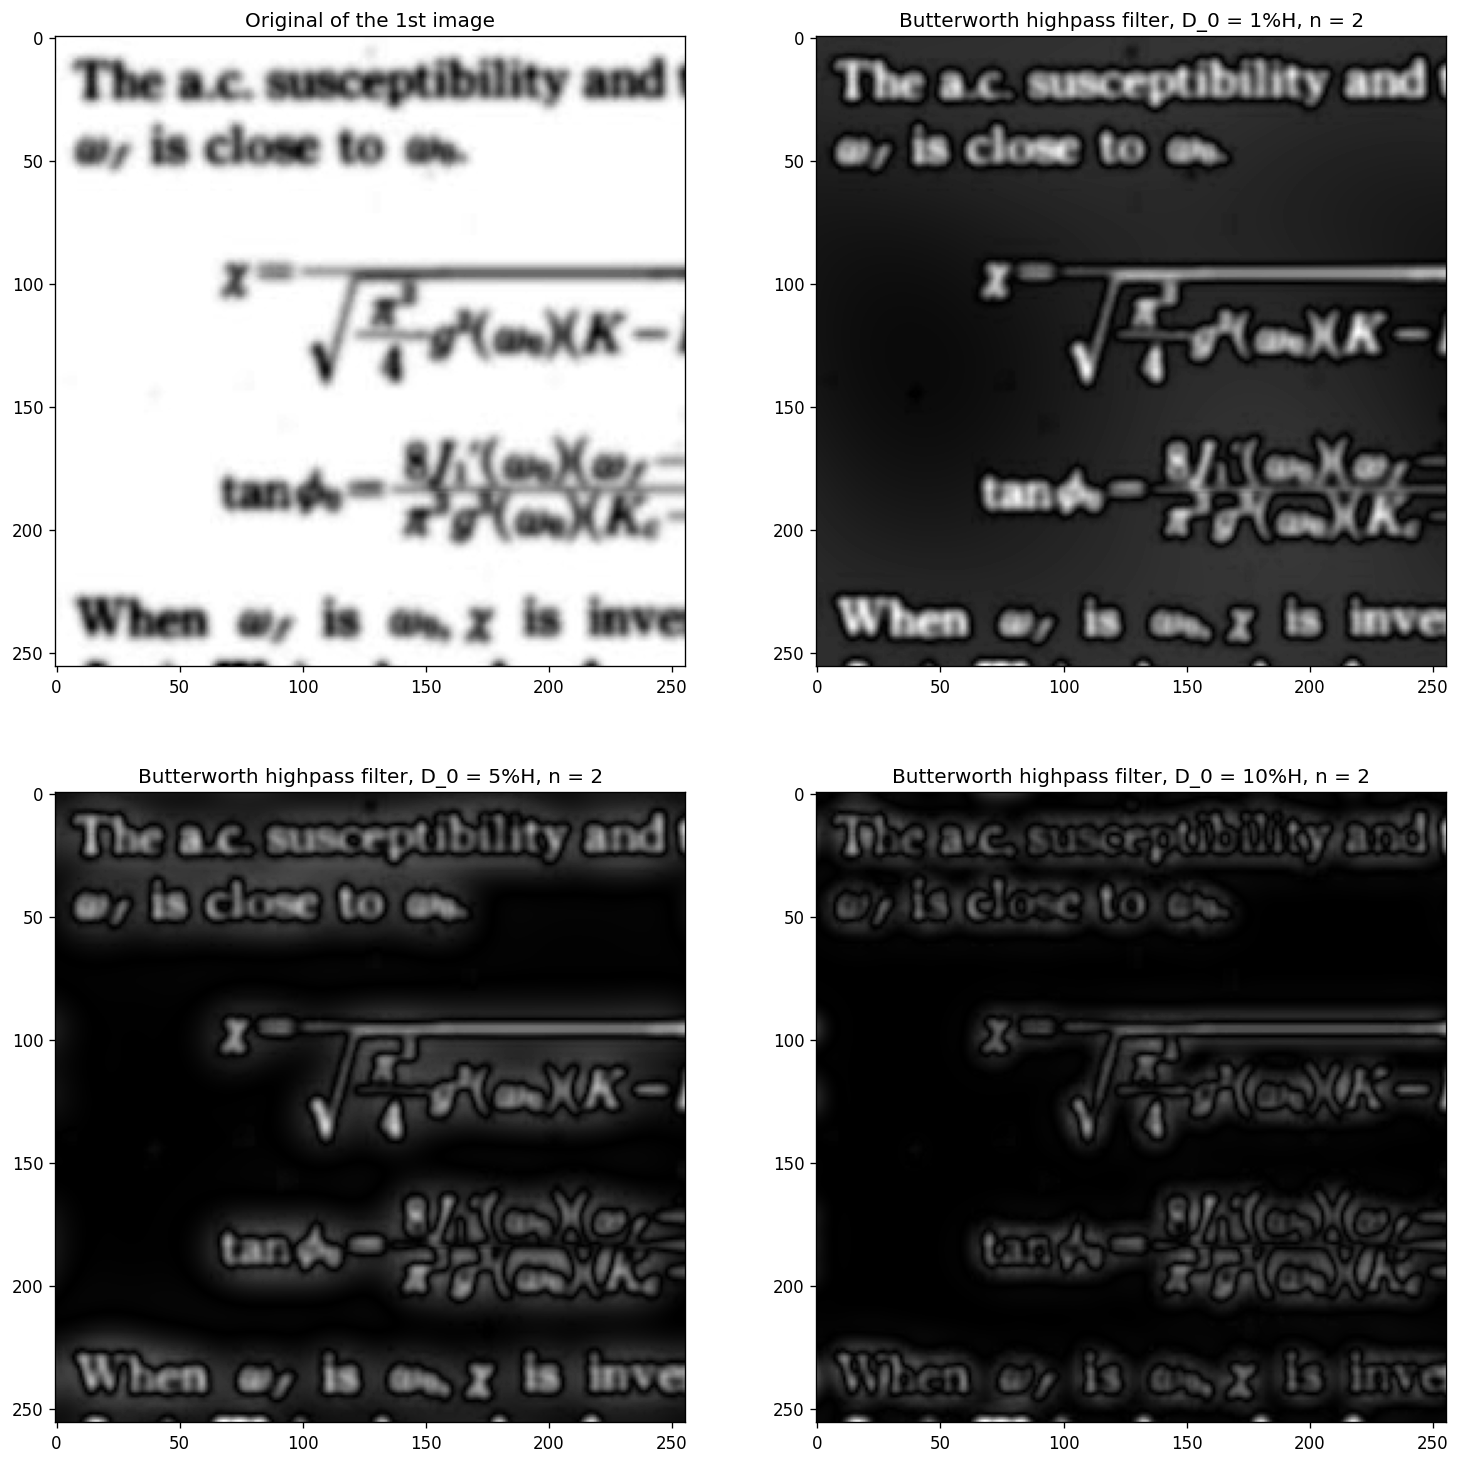

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_bw1i_2, cmap='gray')
axs[0, 1].set_title('Butterworth highpass filter, D_0 = 1%H, n = 2')
axs[1, 0].imshow(np_1_bw2i_2, cmap='gray')
axs[1, 0].set_title('Butterworth highpass filter, D_0 = 5%H, n = 2')
axs[1, 1].imshow(np_1_bw3i_2, cmap='gray')
axs[1, 1].set_title('Butterworth highpass filter, D_0 = 10%H, n = 2')
plt.show()

Наилучшие результаты достигнуты при $D_0 \sim 5\%$. Как и в случае низкочастотных фильтров, высокочастотные фильтры Баттерворта ведут себя более гладко по сравнению с идеальными ФВЧ -- это вполне видно на изображениях выше. При $D_0$ контуры изображения подчеркнуты, вместе с тем отсутствует шум, вносимый идеальным ФВЧ. Переход к более высоким значениям частоты среза для ФВЧ Баттерворта совершается гораздо более плавно.


Рассмотрим результаты обработки изображения фильтром при различных значениях $D_0$ и фиксированном значении порядка $n=4$.

In [16]:
## order 4

np_1_bw1_4, _ = apply_bw_HP(np_1_fft, .01, 4)
np_1_bw2_4, _ = apply_bw_HP(np_1_fft, .05, 4)
np_1_bw3_4, _ = apply_bw_HP(np_1_fft, .10, 4)

np_1_bw1i_4 = np.abs(get_ifft(np_1_bw1_4))
np_1_bw2i_4 = np.abs(get_ifft(np_1_bw2_4))
np_1_bw3i_4 = np.abs(get_ifft(np_1_bw3_4))

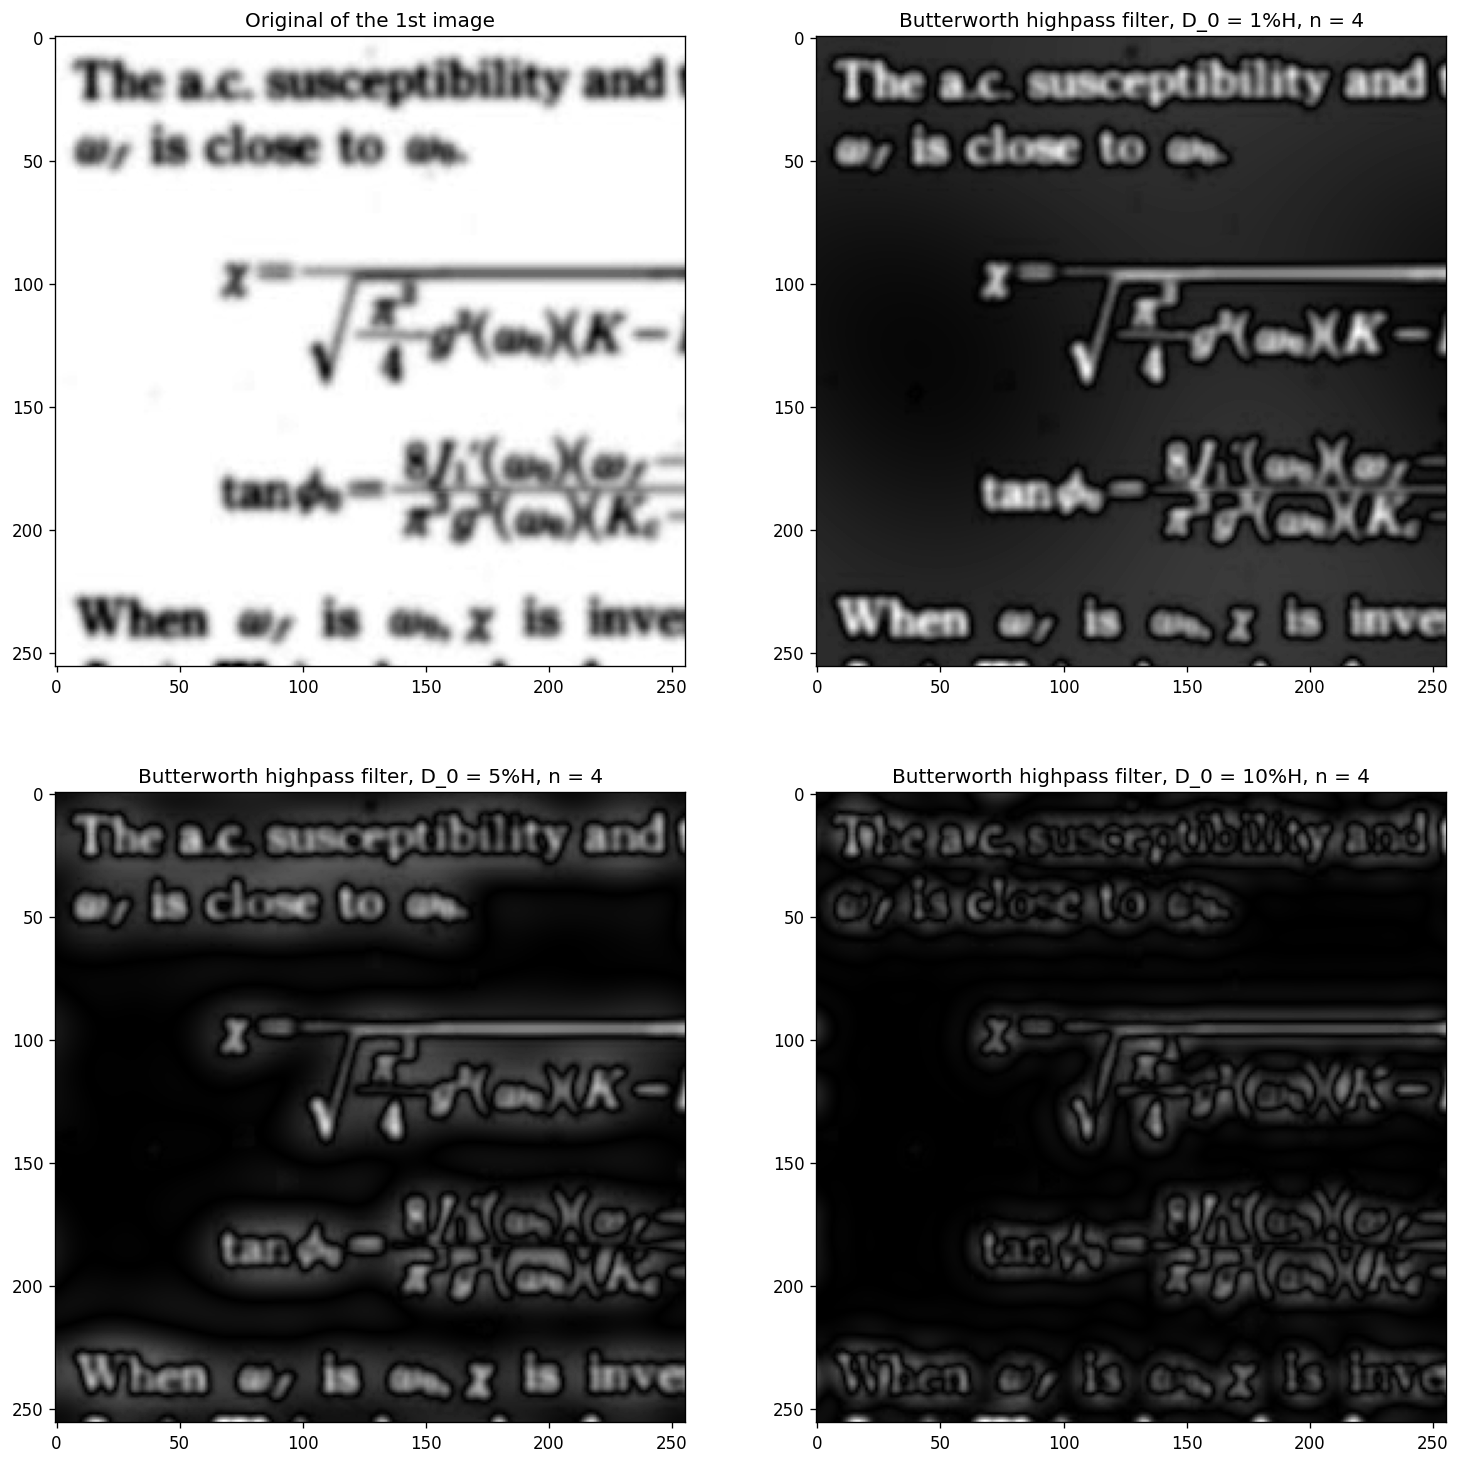

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_bw1i_4, cmap='gray')
axs[0, 1].set_title('Butterworth highpass filter, D_0 = 1%H, n = 4')
axs[1, 0].imshow(np_1_bw2i_4, cmap='gray')
axs[1, 0].set_title('Butterworth highpass filter, D_0 = 5%H, n = 4')
axs[1, 1].imshow(np_1_bw3i_4, cmap='gray')
axs[1, 1].set_title('Butterworth highpass filter, D_0 = 10%H, n = 4')
plt.show()

Наилучшие результаты опять достигаются при $D_0 \sim 5\%$.

Применим фильтр Гаусса для повышения резкости изображения.

In [18]:
np_1_gs1, np_1_gs1_fm = apply_gauss_HP(np_1_fft, .01)
np_1_gs2, np_1_gs2_fm = apply_gauss_HP(np_1_fft, .05)
np_1_gs3, np_1_gs3_fm = apply_gauss_HP(np_1_fft, .10)

np_1_gs1i = np.abs(get_ifft(np_1_gs1))
np_1_gs2i = np.abs(get_ifft(np_1_gs2))
np_1_gs3i = np.abs(get_ifft(np_1_gs3))

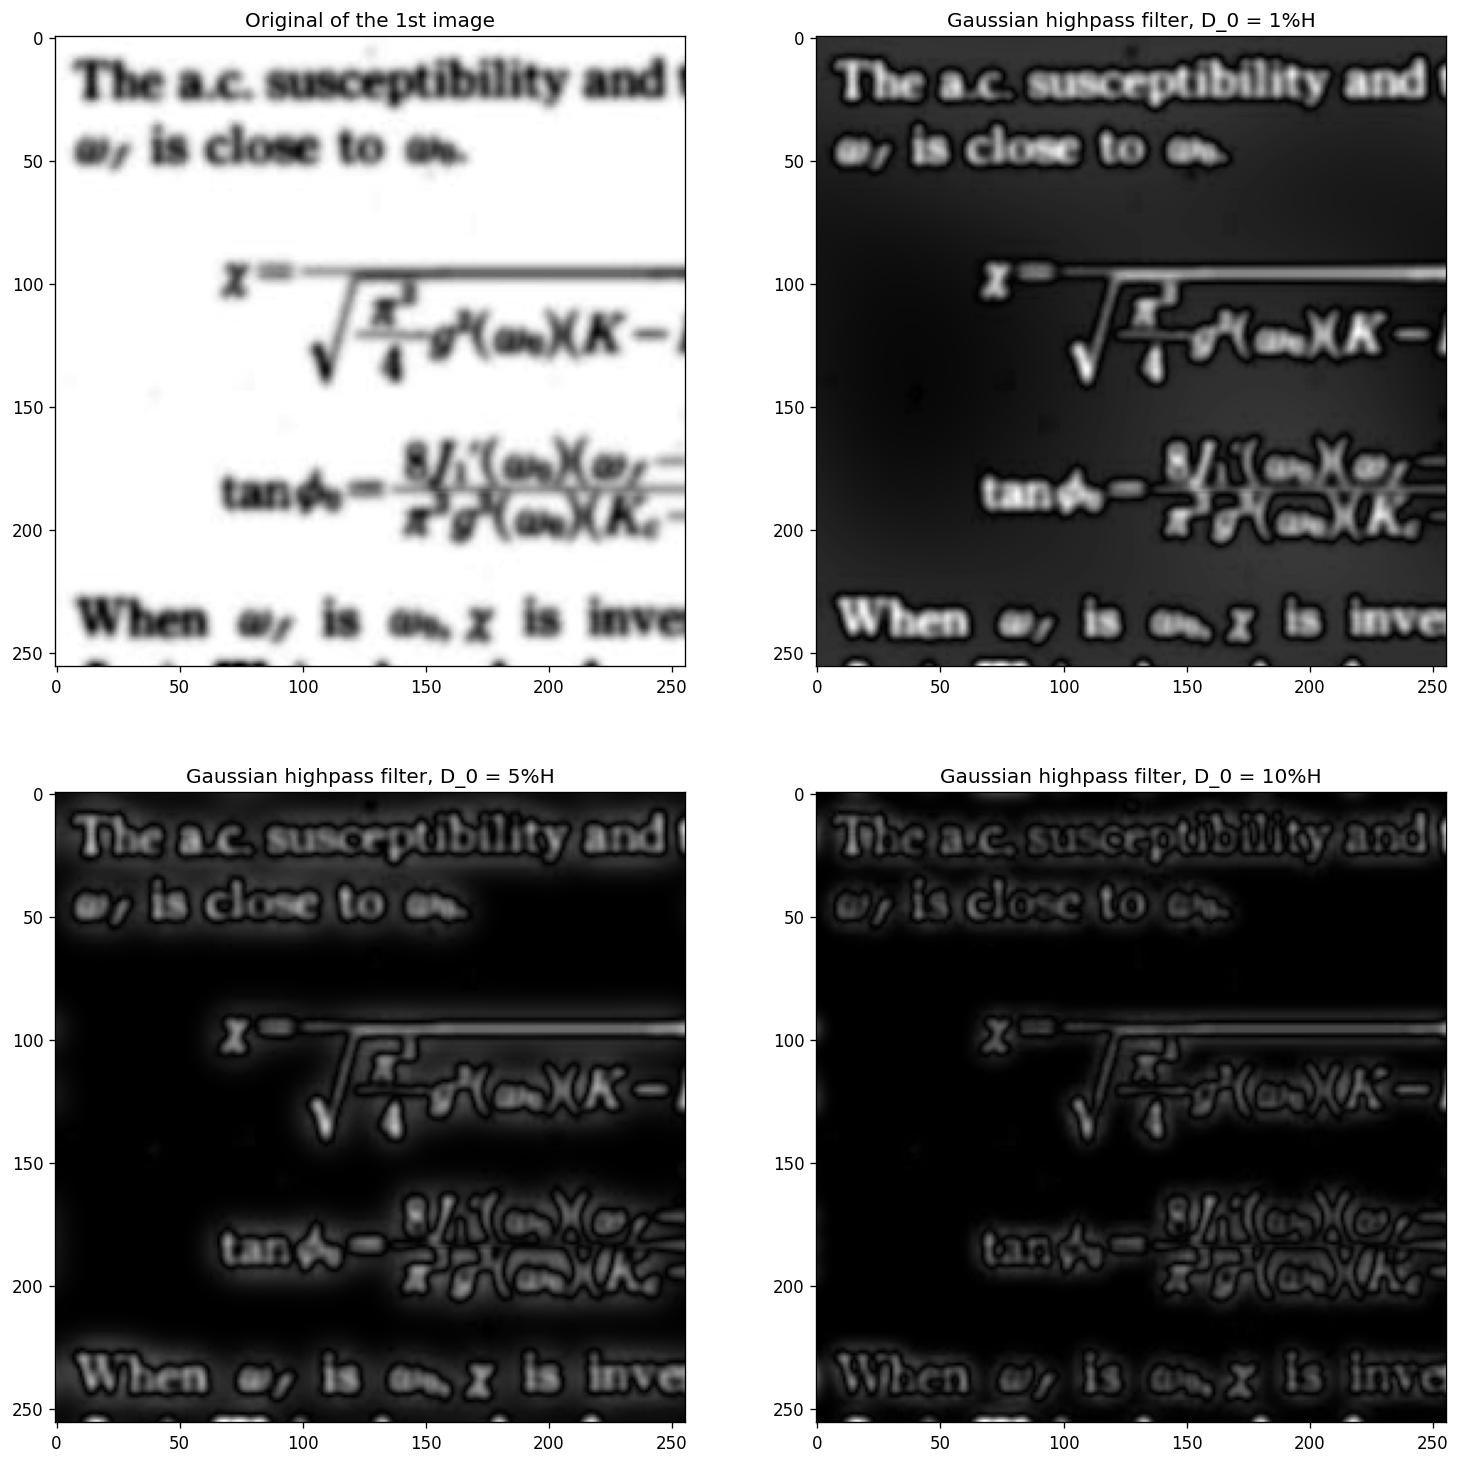

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), dpi=120)
axs[0, 0].imshow(np_1_sum, cmap='gray')
axs[0, 0].set_title('Original of the 1st image')
axs[0, 1].imshow(np_1_gs1i, cmap='gray')
axs[0, 1].set_title('Gaussian highpass filter, D_0 = 1%H')
axs[1, 0].imshow(np_1_gs2i, cmap='gray')
axs[1, 0].set_title('Gaussian highpass filter, D_0 = 5%H')
axs[1, 1].imshow(np_1_gs3i, cmap='gray')
axs[1, 1].set_title('Gaussian highpass filter, D_0 = 10%H')
plt.show()

Наилучшие результаты достигаются при $D_0 \sim 10\%$  -- например, становится хорошо читаемым слово susceptibility, также более четко видно букву $\omega$. Полученные изображения являются более гладкими, чем при использовании предыдущих двух фильтров. Гауссов фильтр дает хорошее качество фильтрации даже для маленьких объектов и тонких полос.